In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


In [3]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.callbacks import EarlyStopping, History, ModelCheckpoint
from keras.layers.core import Flatten, Dense, Dropout, Reshape, Lambda
from keras.layers.normalization import BatchNormalization


In [4]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

In [5]:
import numpy as np

In [21]:
#train_features = np.load('train_preprocesed.npy')
#valid_features = np.load('valid_preprocessed.npy')
valid_features = np.load('/Users/dheerajakshay/Desktop/fyp/Notebooks/valid_preprocessed.npy')
train_fea = np.load('/Users/dheerajakshay/Desktop/fyp/Notebooks/train_preprocesed.npy')

In [23]:
train_dir = "new_train/"
valid_dir = "new_valid/"

In [24]:
classes = os.listdir(train_dir)

In [25]:
# Get the labels

train_labels = []
for c in classes:
    l = [c]*len(os.listdir(train_dir+c+'/'))
    train_labels.extend(l)
    

In [26]:
len(train_labels)

3627

In [27]:
valid_labels = []

for c in classes:
    l = [c]*len(os.listdir(valid_dir+c+'/'))
    valid_labels.extend(l)

In [28]:
onehot_train = to_categorical(LabelEncoder().fit_transform(train_labels))

In [29]:
onehot_valid = to_categorical(LabelEncoder().fit_transform(valid_labels))

In [30]:
vgg16_base = VGG16(include_top=False, weights='imagenet',
                    input_tensor=None, input_shape=(150, 150,3))
# Note that the preprocessing of InceptionV3 is:
# (x / 255 - 0.5) x 2

print('Adding new layers...')
output = vgg16_base.get_layer(index = -1).output  
output = Flatten()(output)
# let's add a fully-connected layer
output = Dense(4096,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(512,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
# and a logistic layer -- let's say we have 200 classes
output = Dense(8, activation='softmax')(output)


vgg16_model = Model(vgg16_base.input, output)
#InceptionV3_model.summary()


Adding new layers...


In [31]:
for layer in vgg16_model.layers[:19]:
    layer.trainable = False

In [32]:

vgg16_model.compile(optimizer="adam",loss="categorical_crossentropy",metrics =["accuracy"])

In [33]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [34]:
train_datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        rotation_range=10.,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True)


val_datagen = ImageDataGenerator()



In [35]:
callbacks = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')        
# autosave best Model
best_model_file = "./data_augmented_weights.h5"
best_model = ModelCheckpoint(best_model_file, monitor='val_acc', verbose = 1, save_best_only = True)

In [36]:
history = vgg16_model.fit_generator(train_datagen.flow(train_features, onehot_train, batch_size=10), nb_epoch=5,
              samples_per_epoch = 3019,                     
              validation_data=val_datagen.flow(valid_features,onehot_valid,batch_size=10,shuffle=False),
                                    nb_val_samples=758,callbacks = [callbacks,best_model])


/Users/dheerajakshay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  after removing the cwd from sys.path.
/Users/dheerajakshay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., callbacks=[<keras.ca..., steps_per_epoch=301, epochs=5, validation_steps=758)`
  after removing the cwd from sys.path.


Epoch 1/5
301/301 [==============================] - 5166s 17s/step - loss: 1.9818 - acc: 0.4707 - val_loss: 0.8988 - val_acc: 0.7447

Epoch 00001: val_acc improved from -inf to 0.74471, saving model to ./data_augmented_weights.h5
Epoch 2/5
301/301 [==============================] - 4765s 16s/step - loss: 1.1418 - acc: 0.6451 - val_loss: 0.6609 - val_acc: 0.7877

Epoch 00002: val_acc improved from 0.74471 to 0.78770, saving model to ./data_augmented_weights.h5
Epoch 3/5
301/301 [==============================] - 4736s 16s/step - loss: 0.9149 - acc: 0.7180 - val_loss: 0.5162 - val_acc: 0.8270

Epoch 00003: val_acc improved from 0.78770 to 0.82698, saving model to ./data_augmented_weights.h5
Epoch 4/5
301/301 [==============================] - 4752s 16s/step - loss: 0.7384 - acc: 0.7601 - val_loss: 0.5414 - val_acc: 0.8405

Epoch 00004: val_acc improved from 0.82698 to 0.84048, saving model to ./data_augmented_weights.h5
Epoch 5/5
301/301 [==============================] - 4786s 16s/step

In [37]:
#model.load_weights("batch_normalized_weights.h5")
vgg16_model.load_weights("data_augmented_weights.h5")

In [38]:
valid_preds = vgg16_model.predict(valid_features, batch_size=5, verbose=1)

1366/1366 [==============================] - 573s 420ms/step


In [39]:
np.save("valid_preds.npy",valid_preds)

In [40]:
valid_preds[0:5]

array([[  9.98814106e-01,   7.47484091e-06,   3.18900817e-07,
          1.11825693e-06,   6.01908482e-07,   4.12180561e-05,
          3.28199021e-05,   1.10239990e-03],
       [  9.98953104e-01,   5.23570416e-05,   7.01997396e-06,
          6.95500285e-06,   6.60936348e-04,   6.33009331e-05,
          2.32149578e-05,   2.33066981e-04],
       [  9.99687314e-01,   1.15267794e-04,   8.17622833e-07,
          1.79542243e-04,   5.20084541e-07,   5.79058360e-06,
          3.93621093e-07,   1.04500432e-05],
       [  9.01356936e-01,   2.46858643e-03,   1.61972526e-03,
          3.20208375e-04,   3.49989645e-02,   3.40302521e-03,
          2.00798027e-02,   3.57526988e-02],
       [  1.80461720e-01,   6.59741182e-03,   2.91885633e-04,
          1.04412891e-03,   6.75169826e-01,   2.07527983e-03,
          8.97229929e-03,   1.25387400e-01]], dtype=float32)

In [41]:
valid_pred_df = pd.DataFrame(valid_preds, columns= os.listdir(train_dir))


In [42]:
valid_pred_df.head()

,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,0.998814,0.000007,3.189008e-07,0.000001,6.019085e-07,0.000041,3.281990e-05,0.001102
1,0.998953,0.000052,7.019974e-06,0.000007,6.609363e-04,0.000063,2.321496e-05,0.000233
2,0.999687,0.000115,8.176228e-07,0.000180,5.200845e-07,0.000006,3.936211e-07,0.000010
3,0.901357,0.002469,1.619725e-03,0.000320,3.499896e-02,0.003403,2.007980e-02,0.035753
4,0.180462,0.006597,2.918856e-04,0.001044,6.751698e-01,0.002075,8.972299e-03,0.125387


In [43]:
rounded_labels = valid_pred_df.round()

In [44]:
rounded_labels.head()

,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [45]:
np_valid_preds = valid_preds

In [46]:
rounded_preds = np_valid_preds.round()

In [47]:
from sklearn.metrics import accuracy_score

In [48]:
accuracy_score(onehot_valid,rounded_preds)

0.88360175695461196

In [107]:
from sklearn.metrics import log_loss
log_loss(onehot_valid,rounded_preds)

2.9509483008573207

In [49]:
from sklearn.preprocessing import LabelEncoder


In [50]:
encoder = LabelEncoder()

In [51]:
encoder.fit(classes)

LabelEncoder()

In [52]:
rounded_labels.to_csv("validation_predictions.csv")

In [53]:
rows = [] 
for row in rounded_labels.head().itertuples():
    rows.append(row)

In [54]:
rows[2][]

SyntaxError: invalid syntax (<ipython-input-54-0e8bb43cd5c1>, line 1)

In [55]:
our_labels = valid_pred_df.round(1)

In [56]:
our_labels[0:20]

,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.2,0.0,0.0,0.0,0.7,0.0,0.0,0.1
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.7,0.0,0.1,0.0,0.0,0.0,0.0,0.1
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
round_rows = []
for row in our_labels.itertuples(index = False):
    round_rows.append(row)

In [58]:
l = []
for row in round_rows:
    l.append((row.index(max(row))))

In [59]:
encoder = LabelEncoder()
encoder.fit(classes)

LabelEncoder()

In [60]:
new_labels = encoder.inverse_transform(l)

In [61]:
len(new_labels)

1366

In [62]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(valid_labels,new_labels)

In [63]:
cf

array([[580,   6,   2,   4,   3,   1,   1,  29],
       [  7,  57,   0,   0,   0,   2,   0,   5],
       [  1,   0,  39,   0,   0,   0,   0,   0],
       [  3,   0,   0,  22,   0,   1,   0,   0],
       [  6,   3,   0,   1, 154,   0,   0,   4],
       [ 10,   0,   0,   1,   0,  96,   0,   2],
       [  0,   1,   0,   0,   0,   0,  64,   0],
       [ 18,   3,  24,   0,   0,   0,   0, 216]])

In [64]:
import matplotlib.pyplot as plt


In [65]:
plt.style.use("seaborn")

In [188]:
#our_labels.to_csv('our_labels.csv',index=True)

In [66]:
import itertools
np.set_printoptions(precision=2)
print(__doc__)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.round(2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Automatically created module for IPython interactive environment


Confusion matrix, without normalization
[[580   6   2   4   3   1   1  29]
 [  7  57   0   0   0   2   0   5]
 [  1   0  39   0   0   0   0   0]
 [  3   0   0  22   0   1   0   0]
 [  6   3   0   1 154   0   0   4]
 [ 10   0   0   1   0  96   0   2]
 [  0   1   0   0   0   0  64   0]
 [ 18   3  24   0   0   0   0 216]]


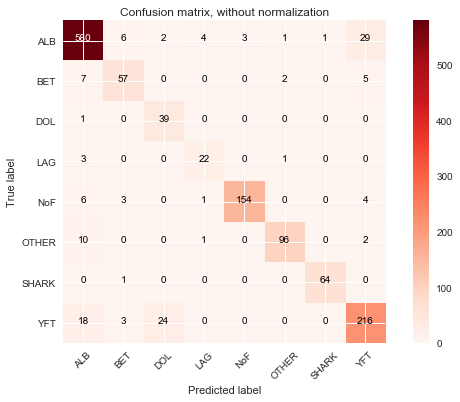

In [67]:
plt.figure()
plot_confusion_matrix(cf, classes=classes,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[ 0.93  0.01  0.    0.01  0.    0.    0.    0.05]
 [ 0.1   0.8   0.    0.    0.    0.03  0.    0.07]
 [ 0.02  0.    0.98  0.    0.    0.    0.    0.  ]
 [ 0.12  0.    0.    0.85  0.    0.04  0.    0.  ]
 [ 0.04  0.02  0.    0.01  0.92  0.    0.    0.02]
 [ 0.09  0.    0.    0.01  0.    0.88  0.    0.02]
 [ 0.    0.02  0.    0.    0.    0.    0.98  0.  ]
 [ 0.07  0.01  0.09  0.    0.    0.    0.    0.83]]


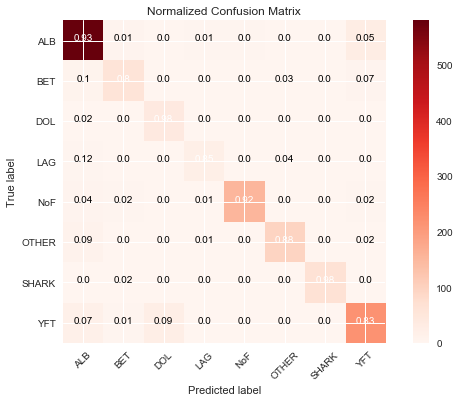

In [68]:
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cf, classes=classes, normalize = True, title= "Normalized Confusion Matrix"
                      )
plt.show()

In [69]:
sum(valid_labels==new_labels)

1228

In [219]:
758-664

94

In [70]:
correct_labels = (valid_labels == new_labels)

In [71]:
incorrect_indexes = np.where(correct_labels==False)[0]
correct_indexes = np.where(correct_labels == True)[0]

In [72]:
valid_paths = []
for c in classes:
    valid_paths.extend(["new_valid/"+c+'/'+name for name in os.listdir("new_valid/"+c+'/')])

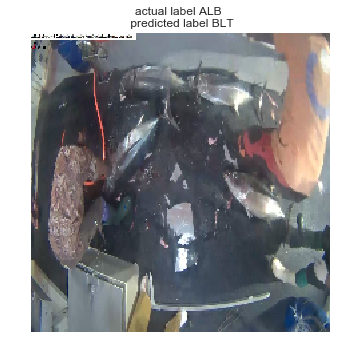

In [75]:
from keras.preprocessing import image
img_path = valid_paths[0]
img = image.load_img(img_path,target_size=(224,224))
plt.title("actual label {} \n predicted label {}".format('ALB','BLT'))
plt.axis("off")
plt.imshow(img)

In [102]:
correct_samples = np.random.choice(correct_indexes,size=5)

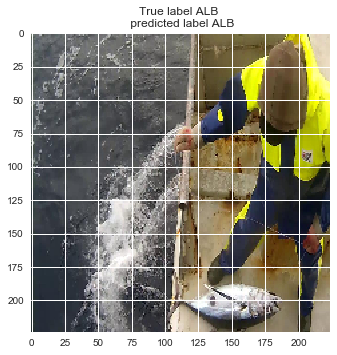

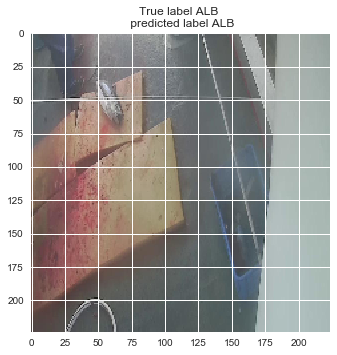

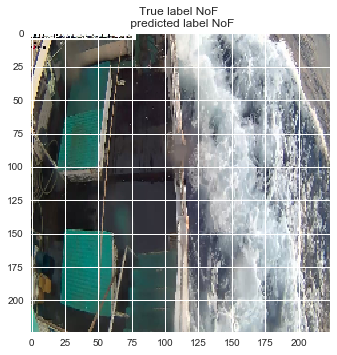

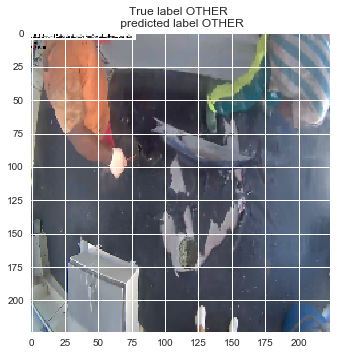

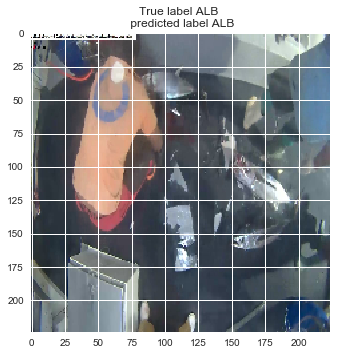

In [106]:
correct_samples = np.random.choice(correct_indexes,size=5)
for i,sample in enumerate(correct_samples):
    img = image.load_img(valid_paths[sample],target_size = (224,224))
    fig = plt.figure()
    plt.title("True label {} \n predicted label {}".format(valid_labels[sample],new_labels[sample]))
    plt.imshow(img)
    

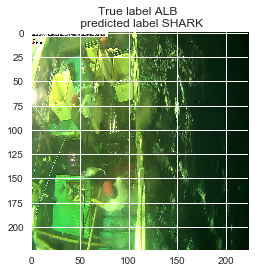

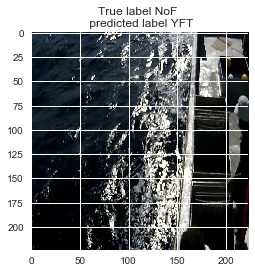

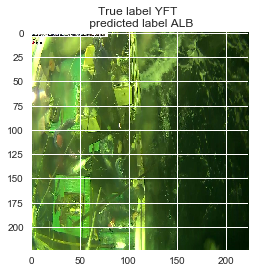

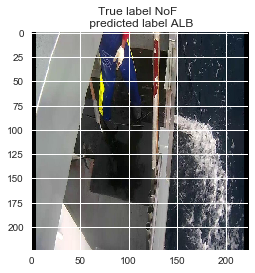

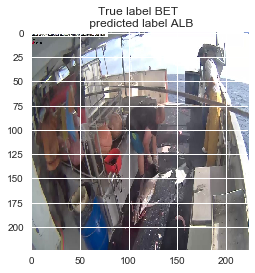

In [294]:
incorrect_samples = np.random.choice(incorrect_indexes,size = 5)
for i,sample in enumerate(incorrect_samples):
    img = image.load_img(valid_paths[sample],target_size = (224,224))
    fig = plt.figure()
    plt.title("True label {} \n predicted label {}".format(valid_labels[sample],new_labels[sample]))
    plt.imshow(img)
    

In [78]:
np_valid_preds.round(2)

array([[ 1.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 1.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 1.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       ..., 
       [ 0.15,  0.  ,  0.  , ...,  0.04,  0.03,  0.75],
       [ 0.03,  0.  ,  0.01, ...,  0.1 ,  0.03,  0.81],
       [ 0.01,  0.  ,  0.  , ...,  0.01,  0.01,  0.95]], dtype=float32)

In [79]:
from sklearn.metrics import log_loss

In [108]:
log_loss(valid_labels,np_valid_preds.round(2))

0.48731699166478559

In [83]:
test_features = np.load("/Users/dheerajakshay/Desktop/fyp/Notebooks/test_preprocesed.npy")
test_preds = vgg16_model.predict(test_features, batch_size=5, verbose=1)


1000/1000 [==============================] - 423s 423ms/step


In [87]:
test_preds.round(2)

array([[ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.65,  0.02,  0.08, ...,  0.08,  0.01,  0.01],
       [ 1.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       ..., 
       [ 0.96,  0.  ,  0.  , ...,  0.01,  0.  ,  0.02],
       [ 1.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.1 ,  0.01,  0.01, ...,  0.32,  0.01,  0.44]], dtype=float32)

In [88]:
submission1 = pd.DataFrame(test_preds.round(2), columns= os.listdir(train_dir))
test_files = os.listdir("test_stg1/test_stg1/")
submission1.insert(0, 'image', test_files)
submission1.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_00005.jpg,0.00,0.00,0.00,0.00,1.0,0.00,0.00,0.00
1,img_00007.jpg,0.65,0.02,0.08,0.15,0.0,0.08,0.01,0.01
2,img_00009.jpg,1.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
3,img_00018.jpg,0.94,0.04,0.00,0.00,0.0,0.01,0.01,0.00
4,img_00027.jpg,0.06,0.00,0.00,0.00,0.0,0.24,0.02,0.68


In [89]:
submission1.to_csv("final_non_clipped.csv",index=False)

In [90]:
clipped_preds = np.clip(test_preds,(1-0.82)/7,0.88)

submission2 = pd.DataFrame(clipped_preds, columns= os.listdir("train/train/"))
submission2.insert(0, 'image', test_files)
submission2.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_00005.jpg,0.025714,0.025714,0.025714,0.025714,0.880000,0.025714,0.025714,0.025714
1,img_00007.jpg,0.645644,0.025714,0.081728,0.151697,0.025714,0.076776,0.025714,0.025714
2,img_00009.jpg,0.880000,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714
3,img_00018.jpg,0.880000,0.039818,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714
4,img_00027.jpg,0.057494,0.025714,0.025714,0.025714,0.025714,0.238961,0.025714,0.675278


In [91]:
submission2.to_csv("final_clipped.csv",index=False)

In [97]:
correct_samples
incorrect_samples

NameError: name 'incorrect_samples' is not defined

/Users/dheerajakshay/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


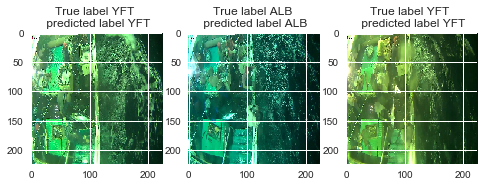

In [94]:
fig = plt.figure(figsize=(8,10))

fig.add_subplot(1,3,1)
sample = correct_samples[0]
img = image.load_img(valid_paths[sample],target_size = (224,224))
plt.title("True label {} \n predicted label {}".format(valid_labels[sample],new_labels[sample]))
plt.imshow(img)
fig.add_subplot(1,3,2)
sample = correct_samples[1]
img = image.load_img(valid_paths[sample],target_size = (224,224))
plt.title("True label {} \n predicted label {}".format(valid_labels[sample],new_labels[sample]))
plt.imshow(img)
fig.add_subplot(1,3,3)
sample = correct_samples[2]
img = image.load_img(valid_paths[sample],target_size = (224,224))
plt.title("True label {} \n predicted label {}".format(valid_labels[sample],new_labels[sample]))
plt.imshow(img)
fig.add_subplot(1,3,3)
sample = correct_samples[2]
img = image.load_img(valid_paths[sample],target_size = (224,224))
plt.title("True label {} \n predicted label {}".format(valid_labels[sample],new_labels[sample]))
plt.imshow(img)

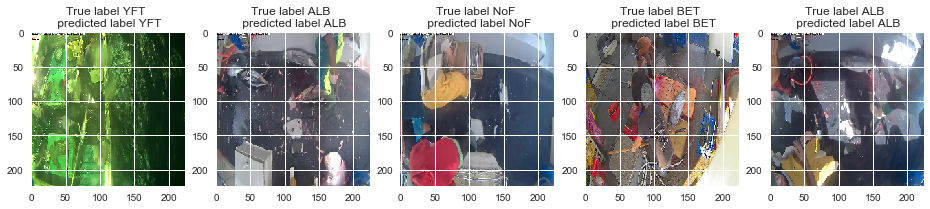

In [101]:
fig = plt.figure(figsize=(16,12))
correct_samples = np.random.choice(correct_indexes,size = 5)
for i,sample in enumerate(correct_samples):
    fig.add_subplot(1,5,i+1)
    img = image.load_img(valid_paths[sample],target_size = (224,224))
    plt.title("True label {} \n predicted label {}".format(valid_labels[sample],new_labels[sample]))
    plt.imshow(img)
    

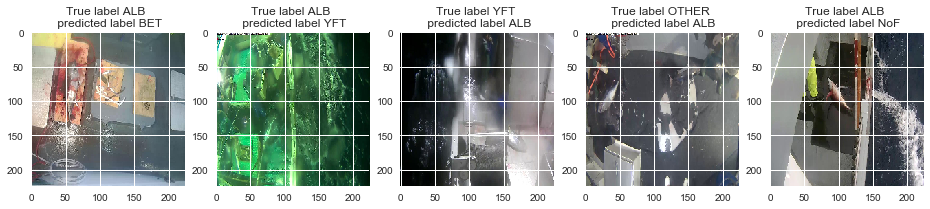

In [100]:
fig = plt.figure(figsize=(16,12))
incorrect_samples = np.random.choice(incorrect_indexes,size = 5)
for i,sample in enumerate(incorrect_samples):
    fig.add_subplot(1,5,i+1)
    img = image.load_img(valid_paths[sample],target_size = (224,224))
    plt.title("True label {} \n predicted label {}".format(valid_labels[sample],new_labels[sample]))
    plt.imshow(img)
    